These are example of how the IRAF tasks used by aXe were replaced with python
------------------------------------------------------------------------

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import gridspec
from astropy.io import fits
from copy import deepcopy
import numpy as np


In [2]:
# make some example images to work with
blank=np.zeros((100,100))
ones=np.ones((100,100))
random1=np.random.rand(100,100) * 100.
random2=np.random.rand(100,100)

# make a binary mask that's randomly seeded
mask=np.random.randint(2, size=np.shape(blank))

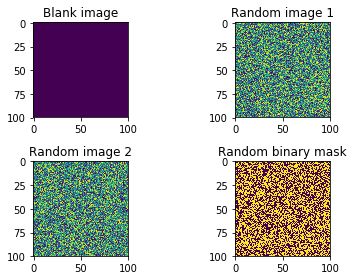

In [3]:

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.set_title('Blank image')
ax0.imshow(blank)
ax1.set_title('Random image 1')
ax1.imshow(random1)
ax2.set_title('Random image 2')
ax2.imshow(random2)
ax3.set_title('Random binary mask')
ax3.imshow(mask)
fig.tight_layout()


**```images.imutil.imreplace```**
--

This is just a straight example of replacing data arrays in a fits image

```
current_image = fits.open('image_name.fits', mode='update')
        current_image['SCI'].data = sci_image
        current_image['ERR'].data = err_image
        current_image['DQ'].data = dq_image
        current_image.close()
```

**```noao.artdata.mknoise```**
--

Translated from the iraf.mknoise task, Poisson noise is added as:

            out = P((in+background)*gain) / gain

- where P(x) is a poisson deviate with mean x
- in  and  out  are  the input  and  final  pixel  values
- background is in counts added to image
- gain is in electrons

The readnoise value is used as the Gaussian sigma. The  sigma is divided by the specified 
gain to convert to  image data  units.   Gaussian  random numbers  of mean zero are then
generated for each pixel and added to the image, or background value for  new  images,  after  the  photon noise is computed.


Generating gaussian and poisson random  numbers  computationally  is the  main  determinant  of  the  execution  time  in this task.  Two things  are  done  to  speed  up  the  task.   
    
 - First,  the  gaussian approximation is  used  for  data  values greater  than  20  (after applying  the  background  and  gain). The square root of the data value is used as the gaussian  sigma about  the  data  value. For values  less  than  20  a  true poisson  deviate is generated.  

What this means: any normal distribution can be specified by the two parameters: mean (μ) and standard deviation (σ). 
Y=(X−μ)/σ. If X has a mean μ and standard deviation σ, Y has mean of 0 and standard deviation of 1. 

- The second speed up is to allow storing a number of normalized  gaussian values   given   by   the package  parameter  ranbuf  as  they  are generated.  If more values than this  are  desired  then  a  uniform random  number  is  used to select one of these stored values.  This applies  to  both  the read  noise  and  poisson   noise   gaussian approximation  though not  the  true  poisson evaluation.

For most purposes this approximation is good and one would need to look  very hard  to  detect  the  nonrandomness  in the noise. However, if one wants to take the extra  computational  time  then by  setting  the ranbuf  parameter  to  zero  each  gaussian  random number  will be generated independently.


In [7]:
##### from copy import deepcopy
background=0.0  # no background, hard coded in axe
gain=1.0  # electrons/dn; hard coded in axe
readnoise=0.1  # electrons 

# make a recognizable image, lets use a gaussian psf
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling.models import Gaussian2D
gauss = Gaussian2D(1, 0, 0, 2, 2)
x = np.arange(-50, 50)
y = np.arange(-50, 50)
x, y = np.meshgrid(x, y)
data_2D = (gauss(x, y) + readnoise * (np.random.rand(100, 100))) * 100.

new_image=deepcopy(data_2D)

# select large values and use simple shot noise
lv = np.where(data_2D >= 20.)
new_image[lv] = np.sqrt(data_2D[lv]) + data_2D[lv]

# create normal, where readnoise is the sigma and the pixel value is the mean
y,x= data_2D.shape
noise = (readnoise * np.random.randn(y,x))
print("Noise range: {} {}".format(np.min(noise), np.max(noise)))
sv = np.where(data_2D <  20.)
new_image[sv] += noise[sv] 

Noise range: -0.3899032166333605 0.4017501860462689


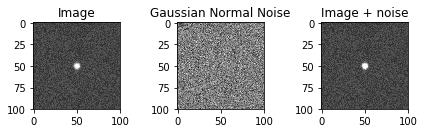

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3)
ax0, ax1, ax2 = axes.flatten()
ax0.set_title('Image')
ax0.imshow(data_2D, cmap='gray', vmin=-10, vmax=45)
ax1.set_title('Gaussian Normal Noise')
ax1.imshow(noise, cmap='gray')
ax2.set_title('Image + noise')
ax2.imshow(new_image, cmap='gray', vmin=-10, vmax=45)
plt.tight_layout()

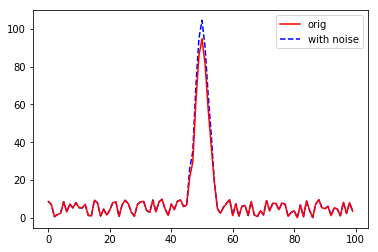

In [9]:
noisy, = plt.plot(new_image[49,:], 'b--', label='with noise')
orig, = plt.plot(data_2D[49, :], 'r-', label='orig')
plt.legend(handles=[orig, noisy])

**```images.imutil.imexpr```**
--

This just evaluates an expression on an image using pixel math, for example:
```
cl> imexpr "a - a/b" pix
            operand a: dev$pix[*,55]
            operand b: a.itime

or

cl> imexpr "a - a / a.itime"
```

Where in IRAF speak, dev$pix is a sample image and a.itime is a value to use for b

In [10]:
image = deepcopy(random1)
b=10. # for example
print("Original:  min({})  max({})".format(np.min(image), np.max(image)))
image -= image / b
print("Updated:  min({})  max({})".format(np.min(image), np.max(image)))


Original:  min(0.0055770139753552606)  max(99.98607420581827)
Updated:  min(0.0050193125778197345)  max(89.98746678523645)


**```noao.artdata.mkpattern```**
--

Make or add patterns in images.

The original task has selection of patterns, this example is for constant which aXe was using to make DQ images:
```
iraf.mkpattern(input=tmpfile1, output="", pattern="constant", option="replace",
                       v1=0.0, v2=0.0, size=1, title="", pixtype="integer",
                       ndim=2, ncols=self.dimension[1], nlines=self.dimension[0],
                       n3=1, n4=1, n5=1, n6=1, n7=1, header="")
```

- input/output: when no output is specified and input doesn't exist a new fits file is created
- pattern: the pixel pattern to use, constant specified to use the value in v1
- option: edit the input image
- v1 ... vn: values to use for pattern
- size: pattern size
- title: image title to put in the header
- pixtype: pixel data type for new images
- ndim: number of dimensions (between 0 and 7)
- ncols: number of columns (first dim)
- nlines: number of lines (second dim)
- n3 .. n7: number of pixels in 3rd-7th dimensions
- header: image or header keyword data file

In [11]:
# for the values above
# lets set self.dimension[1] to 100 self.dimension[0] to 100
image=np.zeros((100,100), dtype=np.int)
hdu=fits.PrimaryHDU(image)
print("Header: {}\nData: {}".format(hdu.header, hdu.data))
#hdu.writeto(filename)

Header: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  100                                                  NAXIS2  =                  100                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

**```stsdas.toolbox.imgtools.xy2rd```**
--

Translate a 2-D image pixel coordinate to  right  ascension and declination.

USAGE  
    xy2rd infile[group] x y
    
    
DESCRIPTION
    This  task uses the group parameters CRVAL, CRPIX, and the CD matrix
    coefficients to translate a pixel coordinate to RA  and  DEC.   Thus
    the epoch of RA and Dec is the same as these group parameters.
    
    
PARAMETERS
    
    infile [string]
        Input  image  name.   Images  are  calculated  one at a time and
        wildcards are not supported.  If no group number  is  specified,
        it assumes the default group of 1.
    
    x [real]
        X pixel coordinate.
    
    y [real]
        Y pixel coordinate.
    
    (hms) = yes [boolean]
        Print   the   output   RA   in  hour-minute-second  and  DEC  in 
        degree-minute-second?
        
        If 'hms=no', output will be in decimal degrees.
    
    (ra) [string]
        The output right ascension.
    
    (dec) [string]
        The output declination.
    
    
EXAMPLES
    1. Calculate RA and DEC of a pixel in the first group:
    
      wf> xy2rd w1234567t.d0h 19 53 
    
    2. Calculate RA and DEC of a point in group 2,  and  produce  output
    in decimal degrees:
    
      wf> xy2rd w1234567t.d0h[2] 12.34 56.78 h-
    



In [1]:
# Replaced with the following stwcs methods
# data = [list(map(float, line.split())) for line in datapoints]        
# skypoints = hstimage.all_pix2world(data,1) #trans points are now in ra and dec from mdrizzle_image

# newhstimage=HSTWCS(self.header_name)
# trans_pts = newhstimage.all_world2pix(skypoints[:,0],skypoints[:,1],1)
